In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [2]:
import torch.nn as nn

# Data source

In [3]:
#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

#import date time
import datetime

In [4]:
# Set start date as 2014-01-01
start_date = datetime.datetime(2014, 9, 16)

# Set end date as today's date
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

In [5]:
#coin -- change this to predict other coins
ticker = 'ETH-USD'

In [6]:
data = yf.download(tickers=ticker, start=start_date, end=end_date, interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [7]:
data.drop(columns=['Adj Close'], inplace=True)

In [8]:
data.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984
2017-11-14,316.763000,340.177002,316.763000,337.631012,1069680000
2017-11-15,337.963989,340.911987,329.812988,333.356995,722665984
2017-11-16,333.442993,336.158997,323.605988,330.924011,797254016
2017-11-17,330.166992,334.963989,327.523010,332.394012,621732992


In [9]:
data.shape

(2055, 5)

### continue -----------------------

In [10]:
data.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984
2017-11-14,316.763000,340.177002,316.763000,337.631012,1069680000
2017-11-15,337.963989,340.911987,329.812988,333.356995,722665984
2017-11-16,333.442993,336.158997,323.605988,330.924011,797254016
2017-11-17,330.166992,334.963989,327.523010,332.394012,621732992


In [11]:
data.info()
#data.dtypes

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2055 entries, 2017-11-09 to 2023-06-25
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2055 non-null   float64
 1   High    2055 non-null   float64
 2   Low     2055 non-null   float64
 3   Close   2055 non-null   float64
 4   Volume  2055 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 96.3 KB


In [12]:
data.describe()

,Open,High,Low,Close,Volume
count,2055.000000,2055.000000,2055.000000,2055.000000,2.055000e+03
mean,1179.929316,1216.001793,1139.662510,1180.490085,1.247372e+10
std,1149.598356,1183.848850,1110.313278,1149.107281,1.044160e+10
min,84.279694,85.342743,82.829887,84.308296,6.217330e+08
25%,221.643501,226.818649,215.612267,221.775711,4.843964e+09
50%,659.185059,691.411011,625.014465,662.809021,9.892586e+09
75%,1813.433411,1844.731506,1770.421631,1813.954468,1.740197e+10
max,4810.071289,4891.704590,4718.039062,4812.087402,8.448291e+10


In [13]:
print('Null Values:', data.isnull().values.sum())
print('If any NA values:', data.isnull().values.any())

Null Values: 0
If any NA values: False


In [14]:
data.tail(10)

,Open,High,Low,Close,Volume
Date,,,,,
2023-06-16,1665.410645,1727.289551,1653.170898,1716.668823,6281023479
2023-06-17,1716.671753,1766.763184,1714.150879,1727.204102,4875187477
2023-06-18,1727.193726,1746.509155,1718.111450,1720.577515,3820038842
2023-06-19,1720.505371,1745.134644,1705.813477,1737.659424,5210480121
2023-06-20,1736.879761,1793.313965,1715.342529,1792.119995,7171072578
2023-06-21,1791.994995,1898.668945,1788.489258,1891.007202,11731457711
2023-06-22,1889.794434,1932.065552,1867.876587,1872.942993,8477657143
2023-06-23,1872.540771,1932.531616,1865.192017,1892.862061,8290615074
2023-06-24,1893.771973,1905.227417,1867.811523,1876.059692,5026191704


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='Date'>

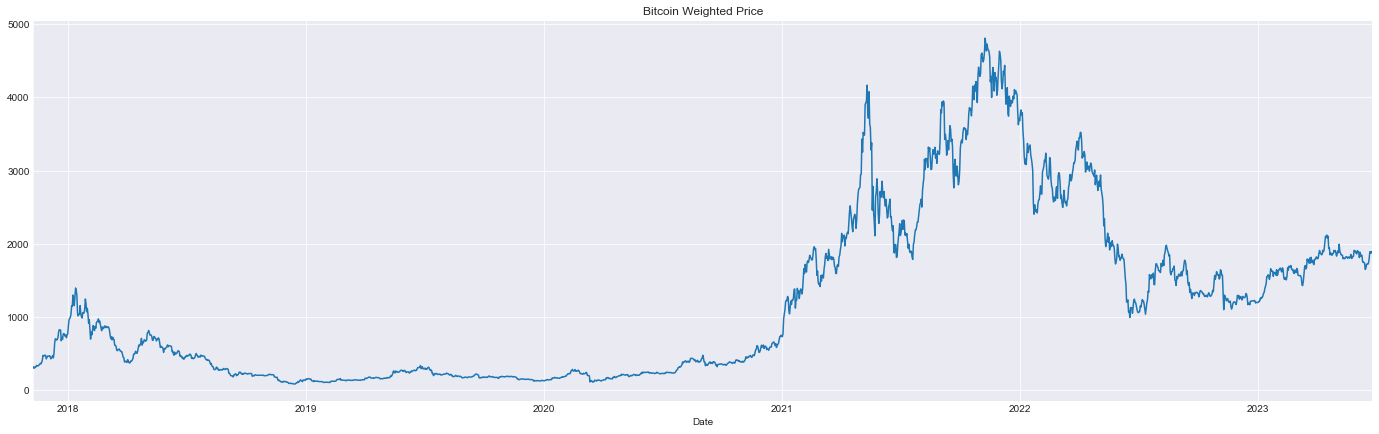

In [15]:
data.Close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

# Lag plot
Lag plot are used to observe the autocorrelation. These are crucial when we try to correct the trend and stationarity and we have to use smoothing functions. Lag plot helps us to understand the data better.

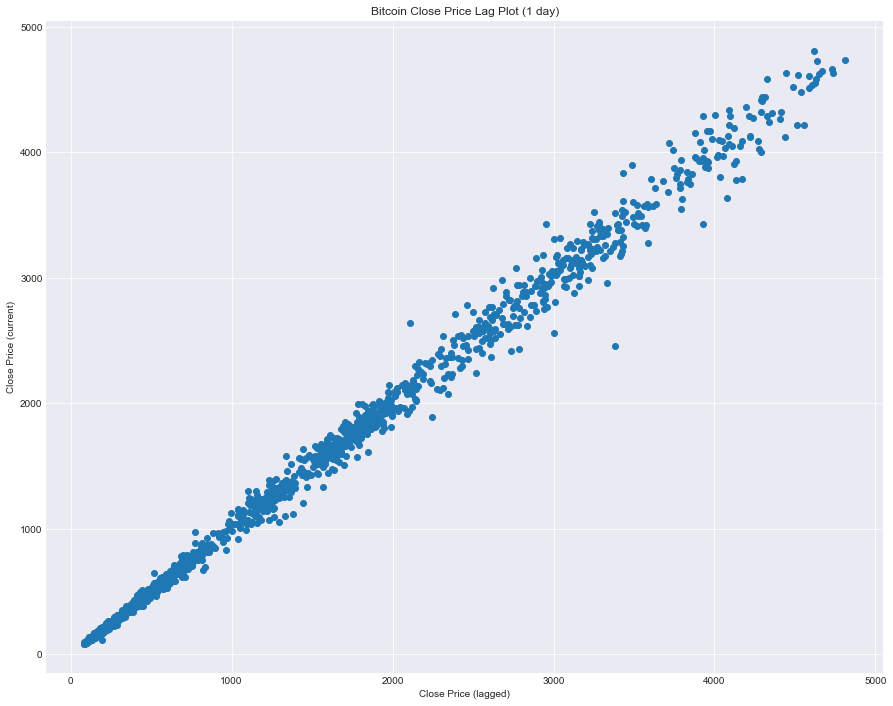

In [16]:
plt.figure(figsize=(15,12))

# Create a lag plot with a lag of 1 day
pd.plotting.lag_plot(data['Close'], lag=1)

# Set plot title and labels
plt.title('Bitcoin Close Price Lag Plot (1 day)')
plt.xlabel('Close Price (lagged)')
plt.ylabel('Close Price (current)')

# Display the plot
plt.show()

In the lag plot of 1 day for Bitcoin's close price, a strong positive slope straight line is observed. This indicates the presence of a significant positive autocorrelation in the data. The positive autocorrelation suggests that the current day's close price is positively related to the previous day's close price. In other words, when the close price increases on a particular day, there is a higher likelihood of it increasing on the following day as well. This pattern implies the existence of short-term momentum or serial dependence in Bitcoin's close price. However, it is important to further validate this inference using statistical tests and consider additional analysis techniques before making any investment decisions.

# Define input and output

In [17]:
# Our input vector will consists of everything except our target, "Closing Price"
X, y = data.drop(columns=['Close']), data.Close.values
X.shape, y.shape

((2055, 4), (2055,))

In [18]:
X

,Open,High,Low,Volume
Date,,,,
2017-11-09,308.644989,329.451996,307.056000,893249984
2017-11-10,320.670990,324.717987,294.541992,885985984
2017-11-11,298.585999,319.453003,298.191986,842300992
2017-11-12,314.690002,319.153015,298.513000,1613479936
2017-11-13,307.024994,328.415009,307.024994,1041889984
...,...,...,...,...
2023-06-21,1791.994995,1898.668945,1788.489258,11731457711
2023-06-22,1889.794434,1932.065552,1867.876587,8477657143
2023-06-23,1872.540771,1932.531616,1865.192017,8290615074


In [19]:
y

array([ 320.88400269,  299.25299072,  314.68099976, ..., 1892.86206055,
       1876.05969238, 1900.50610352])

# Preprocessing data

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))
X_trans

array([[-0.75808772, -0.74905304, -0.75006683, -1.1093405 ],
       [-0.74762413, -0.75305284, -0.76134028, -1.11003634],
       [-0.76683985, -0.75750127, -0.75805212, -1.11422111],
       ...,
       [ 0.60262789,  0.6054018 ,  0.65360481, -0.40071677],
       [ 0.62110075,  0.58233226,  0.65596463, -0.71342918],
       [ 0.60550642,  0.60248474,  0.65870198, -0.53032935]])

Now comes the slightly fiddly part. We want to feed in 100 samples, up to the current day, and predict the next 50 time step values. To do this, we need a special function to ensure that the corresponding indices of X and y represent this structure. Examine this function carefully, but essentially it just boils down to getting 100 samples from X, then looking at the 50 next indices in y, and patching these together. Note that because of this we'll throw out the first 50 values of y.

In [21]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(1907, 100, 4) (1907, 50)


In [22]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

In [23]:
y_mm[0]

array([0.18188281, 0.18820818, 0.17759136, 0.18180983, 0.17155257,
       0.16194976, 0.15409702, 0.1649571 , 0.15994967, 0.16085813,
       0.16604132, 0.16793439, 0.16305556, 0.16665155, 0.16340542,
       0.16348409, 0.16548355, 0.16273513, 0.15496551, 0.14140312,
       0.13120065, 0.13634472, 0.12745556, 0.13516509, 0.13019278,
       0.1282883 , 0.11209972, 0.11146792, 0.10942933, 0.09908896,
       0.09609918, 0.09992381, 0.10001878, 0.10098266, 0.09632297,
       0.09630541, 0.09351764, 0.09306245, 0.08579984, 0.07737411,
       0.07656252, 0.06380579, 0.06564112, 0.06602438, 0.06246034,
       0.06390246, 0.07034692, 0.06265832, 0.06322709, 0.06048859])

In [24]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (1757, 100, 4) (1757, 50)
Testing Shape: (150, 100, 4) (150, 50)


In [25]:
import torch
from torch.autograd import Variable
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
print(len(X_test))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

150


In [26]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([1757, 100, 4]) torch.Size([1757, 50])
Testing Shape: torch.Size([150, 100, 4]) torch.Size([150, 50])


In [27]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[1.59812537e+03, 1.60470410e+03, 1.56539014e+03, 5.80365336e+09],
       [1.57262952e+03, 1.65372498e+03, 1.56898486e+03, 8.80129230e+09],
       [1.64614771e+03, 1.64665161e+03, 1.54666077e+03, 9.18041812e+09],
       [1.56741992e+03, 1.59851758e+03, 1.56380432e+03, 6.58519102e+09]])

In [28]:
y_check[-1]

array([1873.07641602, 1849.04272461, 1848.60314941, 1842.40148926,
       1796.49060059, 1808.01977539, 1796.11486816, 1800.50097656,
       1817.54992676, 1824.12145996, 1821.85961914, 1801.72851562,
       1812.58947754, 1820.47802734, 1804.53137207, 1817.53479004,
       1854.38061523, 1800.09997559, 1805.95373535, 1828.68969727,
       1831.11828613, 1910.91418457, 1893.078125  , 1901.02661133,
       1874.13049316, 1862.20141602, 1907.2565918 , 1892.41247559,
       1890.5135498 , 1811.82836914, 1884.49487305, 1832.39599609,
       1846.30187988, 1840.22521973, 1752.38476562, 1753.4152832 ,
       1742.52868652, 1739.03759766, 1650.51928711, 1665.51977539,
       1716.66882324, 1727.20410156, 1720.57751465, 1737.65942383,
       1792.11999512, 1891.00720215, 1872.94299316, 1892.86206055,
       1876.05969238, 1900.50610352])

In [29]:
data.Close.values[-50:]

array([1873.07641602, 1849.04272461, 1848.60314941, 1842.40148926,
       1796.49060059, 1808.01977539, 1796.11486816, 1800.50097656,
       1817.54992676, 1824.12145996, 1821.85961914, 1801.72851562,
       1812.58947754, 1820.47802734, 1804.53137207, 1817.53479004,
       1854.38061523, 1800.09997559, 1805.95373535, 1828.68969727,
       1831.11828613, 1910.91418457, 1893.078125  , 1901.02661133,
       1874.13049316, 1862.20141602, 1907.2565918 , 1892.41247559,
       1890.5135498 , 1811.82836914, 1884.49487305, 1832.39599609,
       1846.30187988, 1840.22521973, 1752.38476562, 1753.4152832 ,
       1742.52868652, 1739.03759766, 1650.51928711, 1665.51977539,
       1716.66882324, 1727.20410156, 1720.57751465, 1737.65942383,
       1792.11999512, 1891.00720215, 1872.94299316, 1892.86206055,
       1876.05969238, 1900.50610352])

# Build the model

In [30]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [31]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 
            

In [32]:
n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [33]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [34]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.14475, test loss: 0.12202
Epoch: 100, train loss: 0.01422, test loss: 0.02717
Epoch: 200, train loss: 0.00791, test loss: 0.01130
Epoch: 300, train loss: 0.00656, test loss: 0.00654
Epoch: 400, train loss: 0.00600, test loss: 0.00561
Epoch: 500, train loss: 0.00577, test loss: 0.00538
Epoch: 600, train loss: 0.00569, test loss: 0.00536
Epoch: 700, train loss: 0.00565, test loss: 0.00533
Epoch: 800, train loss: 0.00562, test loss: 0.00526
Epoch: 900, train loss: 0.00560, test loss: 0.00522


# Prediction on train set

2055
2055
1907
1907


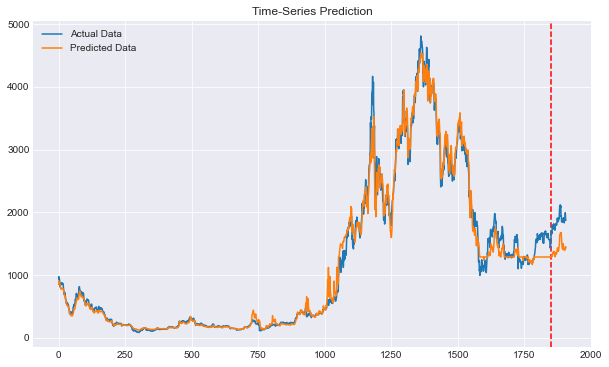

In [35]:
df_X_ss = ss.transform(data.drop(columns=['Close'])) # old transformers
print(len(df_X_ss))
df_y_mm = mm.transform(data.Close.values.reshape(-1, 1)) # old transformers
print(len(df_y_mm))
# split the sequence

past_days = 100
next_pred_days = 50
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, past_days, next_pred_days)


# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))
print(len(df_X_ss))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
print(len(preds))
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

# Prediction on test set

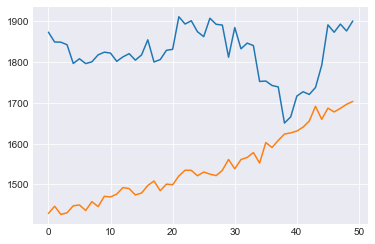

In [36]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.show()

[ 320.88400269  299.25299072  314.68099976 ... 1892.86206055 1876.05969238
 1900.50610352]


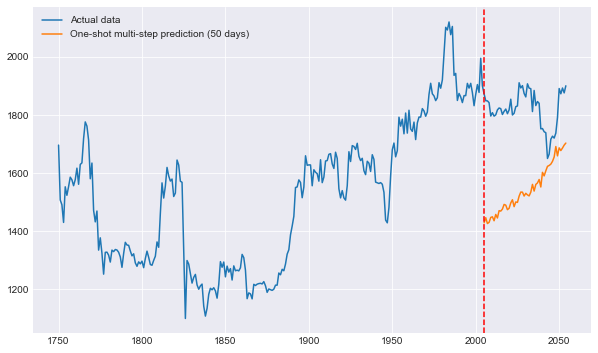

In [37]:
plt.figure(figsize=(10,6)) #plotting
print(y)
a = [x for x in range(1750, len(y))]
plt.plot(a, y[1750:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()

In [38]:
#RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test_target,test_predict))

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
mapescore = mean_absolute_percentage_error(test_target,test_predict)

#Print
print("RMSE score: ", rms)
print("MAPE score: ", mapescore)

RMSE score:  298.7980524900555
MAPE score:  0.15086919975586588
